In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
words = open('makemore/names.txt', 'r').read().splitlines()
print(words[:8], len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'] 32033


In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [101]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g) # the actual embedding matrix
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2 ; kaiming init for tanh nonlinearity
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01 #
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # do not set to zero
b2 = torch.randn(vocab_size,                      generator=g) * 0 # why not torch.zeros ??

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias] # batchnorm params will be trained as well

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12297


In [86]:
(torch.randn(10000) * 0.2).std()

tensor(0.2017)

In [87]:
(5/3) / (30**0.5)

0.3042903097250923

tensor(-0.0047) tensor(0.9893)
tensor(-0.0034) tensor(0.9640)


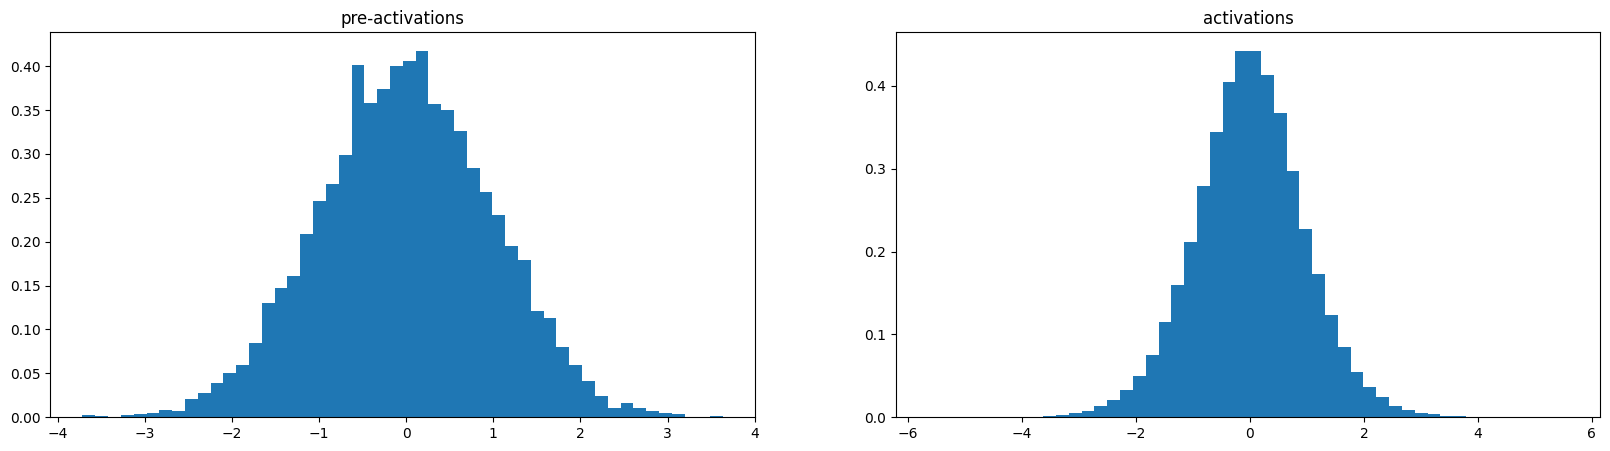

In [83]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5 # divide by sqrt of fan in: number of input elements
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), bins=50, density=True);
plt.title('pre-activations');
plt.subplot(122)
plt.hist(y.view(-1).tolist(), bins=50, density=True);
plt.title('activations');

# mean stays the same, but std grows

In [102]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  # NOTE: do not use biases before a batch normalization layer, no impact: just wasteful; bnbias is used instead
  # after linear or conv layers (multiplications)
  hpreact = embcat @ W1 # + b1 this gets canceled when subtracting the mean # hidden layer pre-activation; we want that to be closer to zero; want it to be roughly gaussian
  # hpreact = bngain * (hpreact - hpreact.mean(dim=0, keepdim=True)) / hpreact.std(dim=0, keepdim=True) + bnbias # normalize the batches to normal distr -> don't want to force normality -> scale and shift
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # could add an eps to bnstdi to avoid dividing by zero
  
  with torch.no_grad(): # this is used during inference time
    # both values just receive a small update
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  # break

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


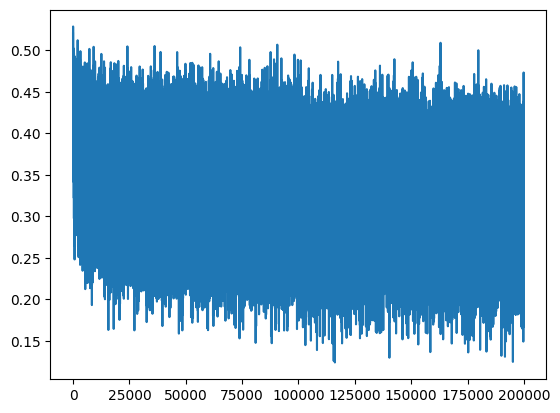

In [103]:
plt.plot(lossi)

In [66]:
# tanh squashes values into range of -1 to 1 smoothly. what does it mean if many values are indeed -1 and 1 ???
h

tensor([[ 0.5503, -0.1064, -0.6658,  ..., -0.3477, -0.9756,  0.8880],
        [-0.9081, -0.1924, -0.1833,  ...,  0.0494,  0.4942,  0.4397],
        [ 0.8016,  0.1173,  0.8237,  ...,  0.2890,  0.6476,  0.8827],
        ...,
        [-0.9190,  0.5208, -0.0346,  ..., -0.0830,  0.8660,  0.8849],
        [-0.9362,  0.0930, -0.2810,  ..., -0.1260,  0.7874,  0.9102],
        [-0.9190,  0.5208, -0.0346,  ..., -0.0830,  0.8660,  0.8849]],
       grad_fn=<TanhBackward0>)

In [67]:
h.shape

torch.Size([32, 200])

Text(0.5, 1.0, 'activations')

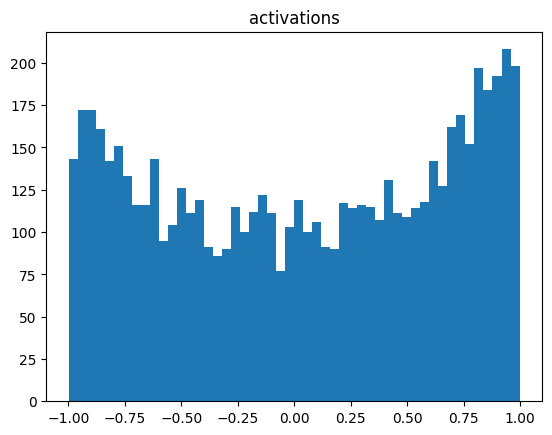

In [68]:
plt.hist(h.view(-1).tolist(), bins=50); # the semicolon hides the view
plt.title("activations")

Text(0.5, 1.0, 'pre-activations')

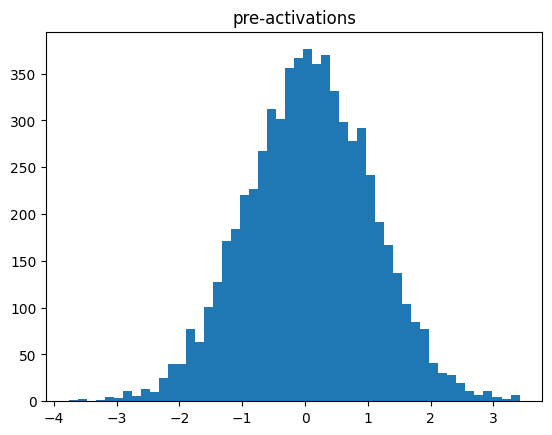

In [69]:
plt.hist(hpreact.view(-1).tolist(), bins=50);
plt.title("pre-activations")

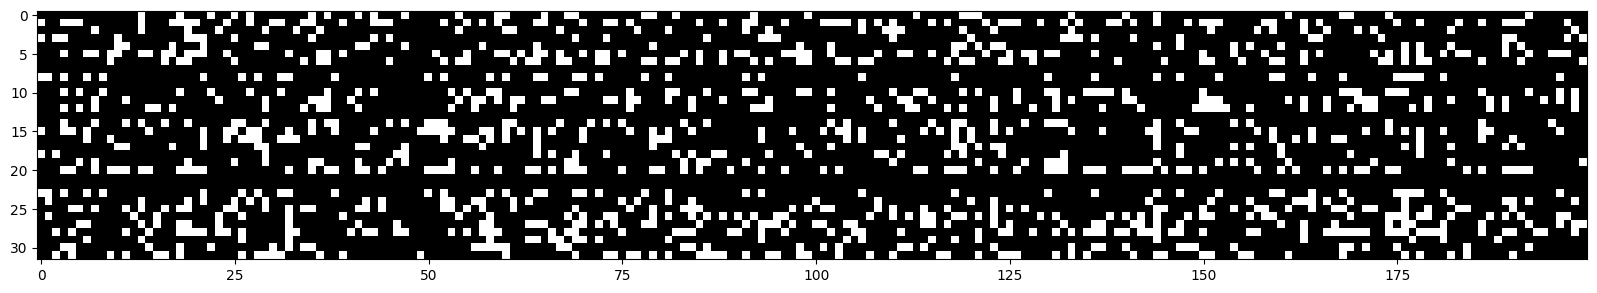

In [73]:
# check how often the activation is in the flat area of the graph
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') # (white if true, black if false)
# a white column indicates a neuron that has never fired and thus cannot learn -> dead neuron, does not create a gradient
# this is a permanent brain damage LOL

In [46]:
h.flatten().shape

torch.Size([6400])

In [22]:
# this is what we expect from the loss at init
torch.tensor(1/27).log()

tensor(-3.2958)

In [99]:
# calibrate batch norm stats

with torch.no_grad():
  emb = C[Xtr] # take the entire training set
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  
  bnmean = hpreact.mean(dim=0, keepdim=True)
  bnstf = hpreact.std(dim=0, keepdim=True)

In [104]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.066591501235962
val 2.1050572395324707


In [105]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carpahzarbriq.
shlimrixtts.
lusslaysierricnenddhn.
frtivgqliyah.
farrichaiirdnsleggyu.
bmanvitte.
sants.
lustvi.
vabbuwatth.
giidryxiidh.
sulipsables.
falia.
gtas.
jasfaylahas.
bduricsydustquovozswy.
bjumillassannyks.
sadlusoffordst.
sramsryndlycpllmanraq.
shelseombriyabhda.
ffxrdustvebndvi.


# pytorchifying lol

In [118]:
from typing import Any


class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])
  
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.5):
    self.eps = eps 
    self.momentum = momentum
    self.training = True
    # params trained with backprop
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers trained with a running momentum update
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # forward pass
    if self.training:
      xmean = x.mean(dim=0, keepdim=True) # batch mean
      xvar = x.var(dim=0, keepdim=True, unbiased=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad(): # not maintained in the computation graph
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean # exponential moving average (?)
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]


class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  # layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3 # 1.0

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [119]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = [] # update to data

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters]) # compare std of update and data: how great are the updates to the values in the tensors

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization
  # break

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

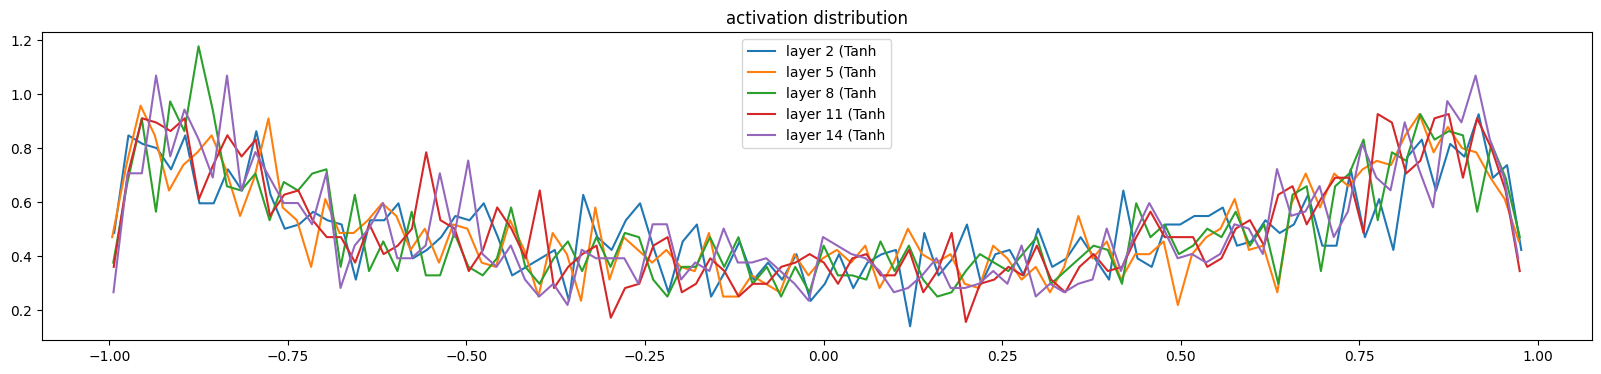

In [120]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.682950e-03
layer 5 (      Tanh): mean -0.000000, std 3.262607e-03
layer 8 (      Tanh): mean +0.000000, std 2.973728e-03
layer 11 (      Tanh): mean +0.000000, std 2.741107e-03
layer 14 (      Tanh): mean -0.000000, std 2.584292e-03


Text(0.5, 1.0, 'gradient distribution')

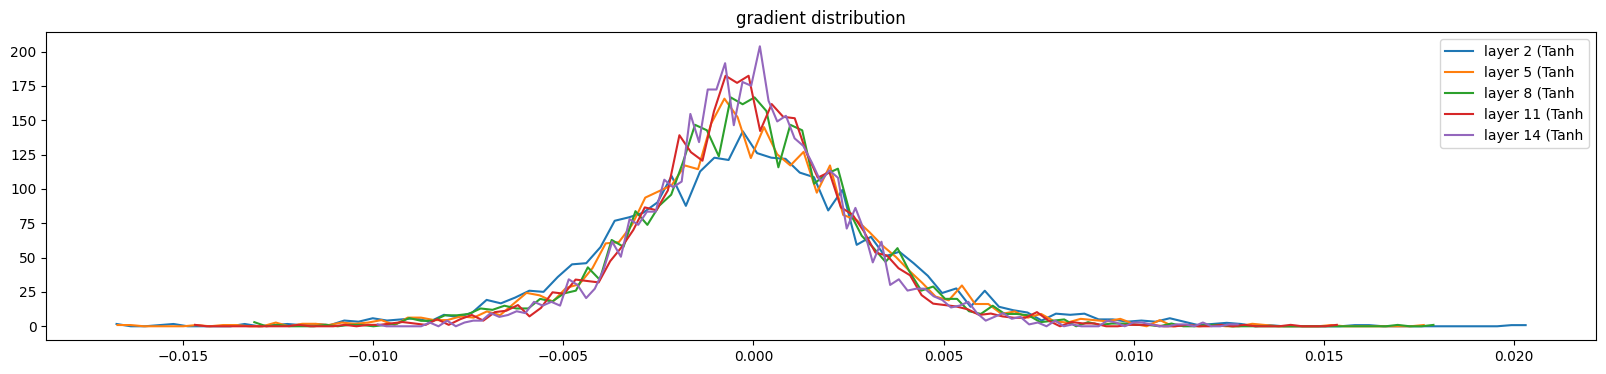

In [121]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 1.019884e-02 | grad:data ratio 1.018844e-02
weight  (30, 100) | mean +0.000092 | std 8.238423e-03 | grad:data ratio 2.635837e-02
weight (100, 100) | mean +0.000031 | std 7.318102e-03 | grad:data ratio 4.377138e-02
weight (100, 100) | mean -0.000019 | std 6.662021e-03 | grad:data ratio 3.949894e-02
weight (100, 100) | mean -0.000019 | std 5.821513e-03 | grad:data ratio 3.468160e-02
weight (100, 100) | mean +0.000053 | std 5.445292e-03 | grad:data ratio 3.243365e-02
weight  (100, 27) | mean -0.000165 | std 1.046843e-02 | grad:data ratio 6.281257e-02


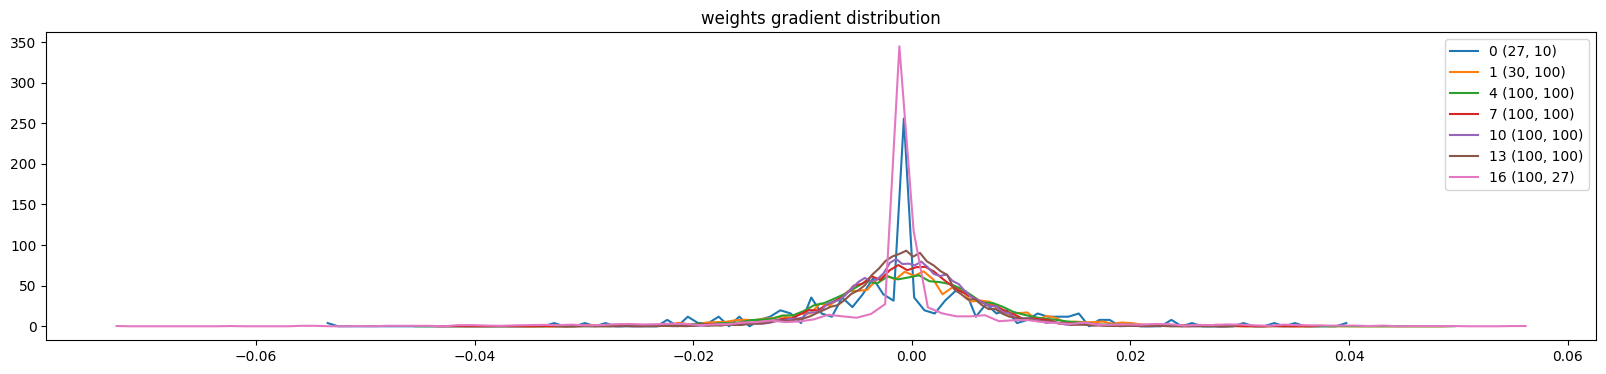

In [122]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

# last layer is a trouble maker, way bigger values than the other layers.

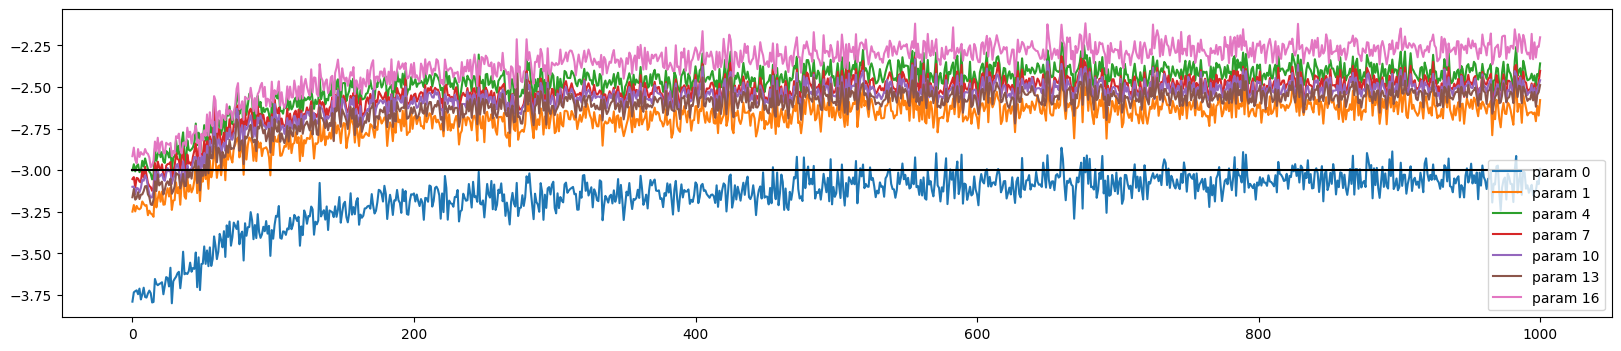

In [123]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
